In [11]:
#### Packages ####
from pathlib import Path
from argparse import Namespace
from collections import Counter
import json
import os
import string
import time
import math
import numpy as np
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd #just to open our file
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10, 10]
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#### Setting Direc
import os
os.chdir("/content/drive/My Drive/LMU-Statistik/SS22/WWC Hackathon for Social Good/wwcode-hackathon-2022/data")

## Fake News Classifier Model

Use Kaggle Dataset to train a fake news classifier for newspaper coverage.

train.csv: A full training dataset with the following attributes:
- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable
    - 1: unreliable
    - 0: reliable


In [7]:
fn_train = pd.read_csv("fake-news/train.csv")
fn_test = pd.read_csv("fake-news/test.csv")

In [8]:
fn_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [14]:
print("Shape of dataset ", fn_train.shape)
print("Columns ", fn_train.columns)
print("Missing values:\n", fn_train.isna().sum())

Shape of dataset  (20800, 5)
Columns  Index(['id', 'title', 'author', 'text', 'label'], dtype='object')
Missing values:
 id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [15]:
fn_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [20]:
# Drop rows with missing data
fn_train_no_na = fn_train.dropna(axis=0, how="any")
fn_train_no_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18285 non-null  int64 
 1   title   18285 non-null  object
 2   author  18285 non-null  object
 3   text    18285 non-null  object
 4   label   18285 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 857.1+ KB


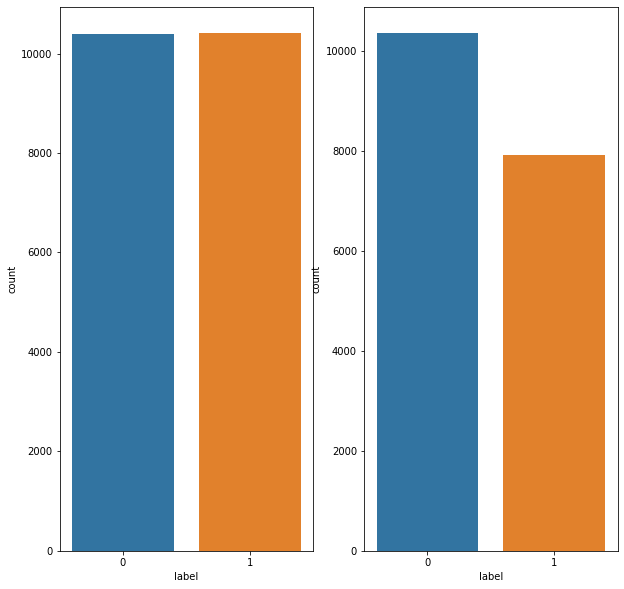

In [22]:
# Check for class balance
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.countplot(x="label", data=fn_train, ax=ax1)
sns.countplot(x="label", data=fn_train_no_na, ax=ax2)
plt.show()

The is slight imbalance after removing the missing values which where mostly present in the 'unreliable' news. The ratio between 'fake' and 'reliable' went from 1:1 to 4:5.

In [23]:
# Continue to work without missing data rows
fn_train.dropna(axis=0, how="any", inplace=True)

## Understand the structure and properties of articles classified as incredible/fake

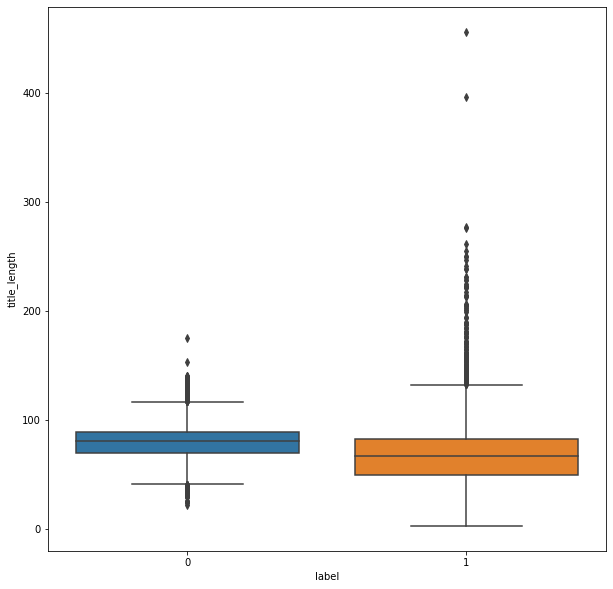

In [24]:
# Inspecting the titles/headlines of the articles
fn_train['title_length'] = fn_train['title'].apply(lambda x: len(x))
sns.boxplot(y='title_length', x='label', data=fn_train)
plt.show()

The titles of credible news are mostly a bit longer than the ones of fake news, but there is an overlap in the IQRs and also the fake news have a lot of outliers upwards, but there are also some articles with really short titles, as the minimum in this category is visibly below the other's minimum. In general, we can say that the title lengths of fake news cover a larger range than the lengths of credible news.

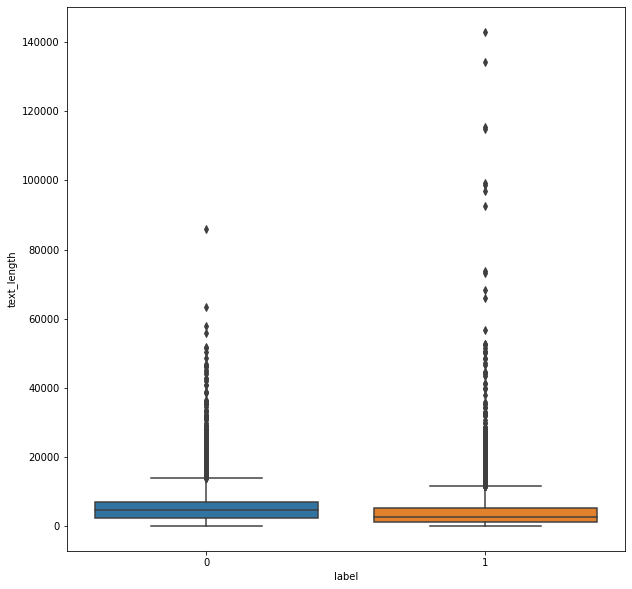

In [25]:
# Inspecting the article lengths
fn_train['text_length'] = fn_train['text'].apply(lambda x: len(x))
sns.boxplot(y='text_length', x='label', data=fn_train)
plt.show()

The credible news seem to be a bit longer in general. The median and IQR lie above those for fake news. Both categories have a lot of outliers, though the outliers in fake news are spread out more towards really long articles with a length nearly twice as much as furthest outlier in the credible category.  
Both catories have a minimum at zero, that needs to be considered in further analysis and might count as missing data.

In [26]:
fn_train.describe()

,id,label,title_length,text_length
count,18285.000000,18285.000000,18285.000000,18285.000000
mean,10409.807383,0.433361,74.702324,4800.181843
std,5998.216236,0.495553,22.648026,5225.865069
min,0.000000,0.000000,3.000000,1.000000
25%,5217.000000,0.000000,61.000000,1834.000000
50%,10422.000000,0.000000,76.000000,3694.000000
75%,15603.000000,1.000000,88.000000,6535.000000
max,20799.000000,1.000000,456.000000,142961.000000


The minimum length of a title is 3 and the minimum length of a text 1 character. That doesn't make much sense.

In [27]:
fn_train[fn_train['title_length'] < 5]

,id,title,author,text,label,title_length,text_length
2561,2561,Wow!,Gillian,http://www.thepoliticalinsider.com/wikileaks-c...,1,4,1214
15728,15728,Rum,Kantucky,RIGHT REVERAND POPE JEREMIAH GOLDSTIEN says: \...,1,3,422
17081,17081,EPIC,Eric Odom,It didn’t take us long to think of a word to d...,1,4,2120


In [28]:
fn_train[fn_train['text_length'] < 5]

,id,title,author,text,label,title_length,text_length
82,82,Huma’s Weiner Dogs Hillary,Steve Sailer,,1,26,1
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,,1,91,1
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,,1,72,1
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,,1,98,1
592,592,Is your promising internet career over now Vin...,newsbiscuit editorial team,,1,99,1
...,...,...,...,...,...,...,...
19857,19857,"A Fifth Clinton Presidency? Hill, No!",Michelle Malkin,,1,37,1
19929,19929,98% of public now ‘really looking forward’ to ...,NewsBiscuit,,1,100,1
20242,20242,Radio Derb Transcript For October 21 Up: The M...,John Derbyshire,,1,78,1
20264,20264,Pro-sovereignty Legislators Demand That Admini...,Brenda Walker,,1,73,1


The short titles convey a meaning, but the short texts can be counted as missing data.

In [29]:
# Remove rows where text is empty
fn_train = fn_train[fn_train['text_length'] > 5]

In [30]:
fn_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18210 entries, 0 to 20799
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            18210 non-null  int64 
 1   title         18210 non-null  object
 2   author        18210 non-null  object
 3   text          18210 non-null  object
 4   label         18210 non-null  int64 
 5   title_length  18210 non-null  int64 
 6   text_length   18210 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


75 rows were removed.

In [32]:
fn_train.describe()

,id,label,title_length,text_length
count,18210.000000,18210.000000,18210.000000,18210.000000
mean,10411.604558,0.431082,74.720703,4819.947666
std,5996.639216,0.495241,22.618403,5227.513273
min,0.000000,0.000000,3.000000,9.000000
25%,5220.500000,0.000000,61.000000,1855.000000
50%,10424.500000,0.000000,76.000000,3715.000000
75%,15602.750000,1.000000,88.000000,6547.000000
max,20799.000000,1.000000,456.000000,142961.000000


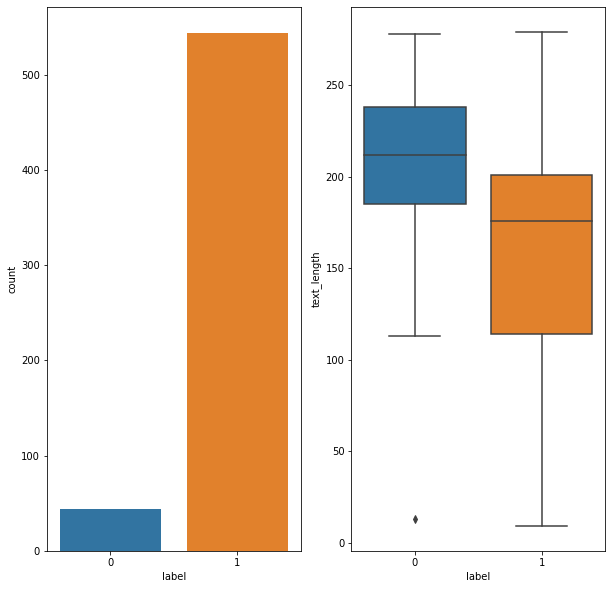

In [42]:
# Look at shrt articles and their categories
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.countplot(x="label", data=fn_train[fn_train['text_length'] < 280], ax=ax1)
sns.boxplot(y='text_length', x='label', data=fn_train[fn_train['text_length'] < 280], ax=ax2)
plt.show()

Really short articles (same length as a tweet) are mostly found in the fake news category, but there are also some in the reliable news. 

In [45]:
fn_train[(fn_train['text_length'] < 280) & (fn_train['label'] == 0)].head()

,id,title,author,text,label,title_length,text_length
81,81,Turkey Threatens to Open Migrant ’Land Passage...,Breitbart London,(AP) — Turkey’s minister in charge of Europ...,0,78,208
2349,2349,Serb Officials Warn Of Another War In The Balkans,Breitbart London,"BELGRADE, Serbia (AP) — Serbian officials w...",0,49,212
3030,3030,Jury Deadlocks in Bill Cosby Trial Mistrial De...,Breitbart News,"NORRISTOWN, Pa. (AP) — Bill Cosby’s trial o...",0,64,238
3076,3076,Muslims Protest with Street Prayer in Paris Su...,Breitbart London,PARIS (AP) — Hemmed in and closely watched ...,0,50,222
3651,3651,Italian Court Convicts Jihadists Plotting Rome...,Breitbart London,MILAN (AP) — An Italian court has convicted...,0,53,220


In [46]:
fn_train[(fn_train['text_length'] < 280) & (fn_train['label'] == 0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 81 to 20685
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            44 non-null     int64 
 1   title         44 non-null     object
 2   author        44 non-null     object
 3   text          44 non-null     object
 4   label         44 non-null     int64 
 5   title_length  44 non-null     int64 
 6   text_length   44 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 2.8+ KB


The short articles in the reliable category seem to be subheadings of the actual articles. There are 44 of these in the training data. 

## Pre-Processing

In [49]:
#### Packages ####
fn_train['text'][2]

'Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but the lessons are probably universal. \nBack in the early spring of 2003, George W. Bush initiated the invasion of Iraq. One of his key public reasons for doing so was the claim that the country’s dictator, Saddam Hussein, was on the verge of developing nuclear weapons and was hiding other weapons of mass destruction. The real reason went beyond that charge and included a long-range plan for “regime change” in the Middle East. President George W. Bush and Vice President Dick Cheney receive an Oval Off